In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [4]:

def make_name(s1,s2): 
    out_name = ""
    if not (pd.isna(s1) and pd.isna(s2)): 
        out_name = "_".join( [e for e in [s1,s2] if not pd.isna(e)])
    return out_name

In [5]:
data = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',skiprows=4)

In [6]:
data = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',skiprows=4)
col_info = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',nrows=4)
#use this to tell if its residential, industrial or other 
column_identity = col_info.iloc[[0,1],:]
#iterate through all the column names and make them be "residential_consumpition","industrial_consumption" etc 
name_cats = list() 
for col_names in col_info:
    col = col_info[col_names] 
    n1 = col.iloc[0] 
    n2 = col.iloc[1] 
    new_name = make_name(n1,n2)
    name_cats.append(new_name)
#define the actual new neames

new_name = [ f"{a}_{b}" if a  else b for a,b in zip(name_cats,data.keys().to_list()) ] 
#replace the column names 
data.columns = new_name

In [20]:
doe_map = {e['state_id']:e['doe_climate_zone'] for i,e in data.iterrows()}

#observing differences in GHC emissions 

The dataset records GHC emissions as estimates by  type (Commercial,industry,transportation, residential)  and by  source  ( Natural Gas, Electricity,diesel,gasoline) . In this work we are interested in observing variations in emission's values by DOE climate zones.  Said zones divide the united states into regions of similar climate. Such that cities/counties within the same zone can expect similar temperature/wweather patterns. Their emissions may also be most similar as needs to for cooling/heating/ will be most similar within similar temperature regions.  We will start our analysis by comparing emission value seperately for each  of the categories of (commesial, industry, transporation and  residential)

Our statistical analysis 

In [44]:
i_col

'On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'

In [46]:
col_name_paris = [
    ('Gasoline of On Road Transportation','On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Diesel of On Road Transportation', 'On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Electricity of Residential','Residential_Electricity_GHG emissions mtons CO2e'),
    ('Natural Gas of Residential', 'Residential_Natural Gas_GHG emissions mtons CO2e.1'),
    ('Electricity Commercial','Commercial_Electricity_GHG emissions mtons CO2e.2'),
    ('Natural Gas Commerical ','Commercial_Natural Gas_GHG emissions mtons CO2e.3'),
    ('Electricity Industry','Industry_Electricity_GHG emissions mtons CO2e.4'),
    ('Natural Gas','Industry_Natural Gas_GHG emissions mtons CO2e.5'),


]

In [62]:
import os 
os.makedirs('./figure1_content/',exist_ok=True)

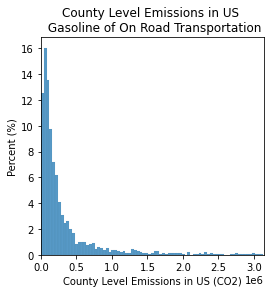

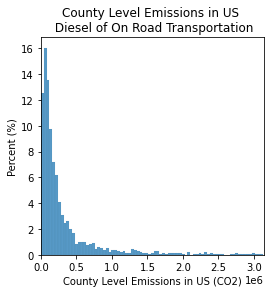

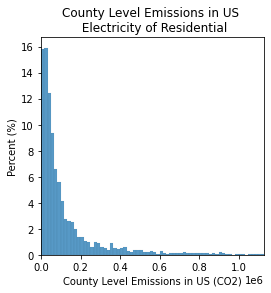

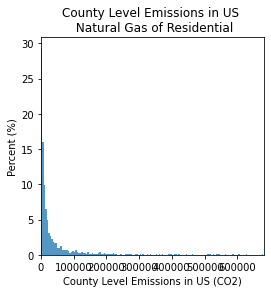

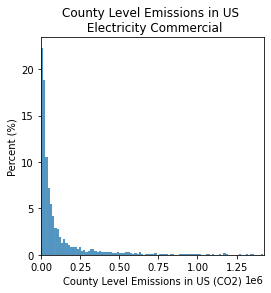

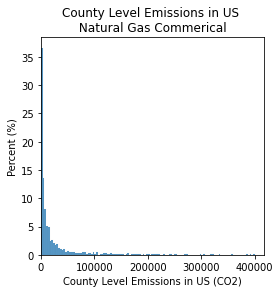

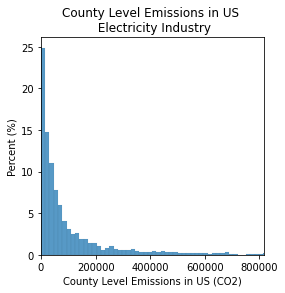

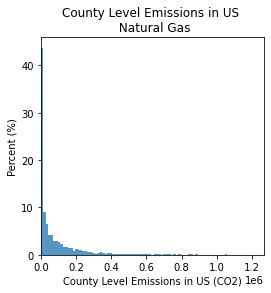

In [71]:
for  i,(name , icol) in enumerate(col_name_paris): 
    plt.figure(figsize=(4,4))
    data_stats=  data[icol].describe()
    mu = data_stats['mean']
    std = data_stats['std']  
    sns.histplot(data=data,x=icol,stat='percent')
    plt.xlim([0, mu + 2*std]) #do this so data is more readable 
    plt.title(f"County Level Emissions in US \n {name}") 
    plt.xlabel("County Level Emissions in US (CO2)")
    plt.ylabel("Percent (%)")
    save_name = name.replace(" ","_")
    plt.savefig(f"./figure1_content/figure1_county_{save_name}_use.png")


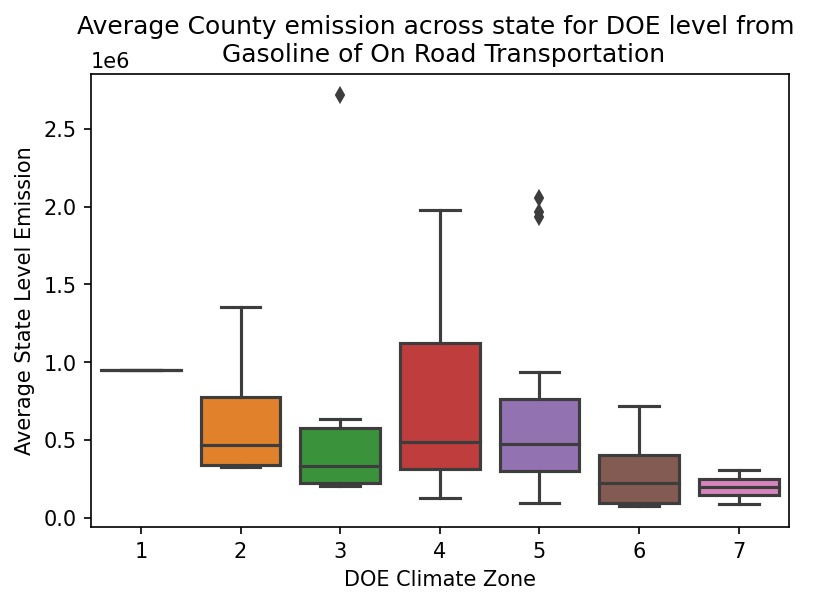

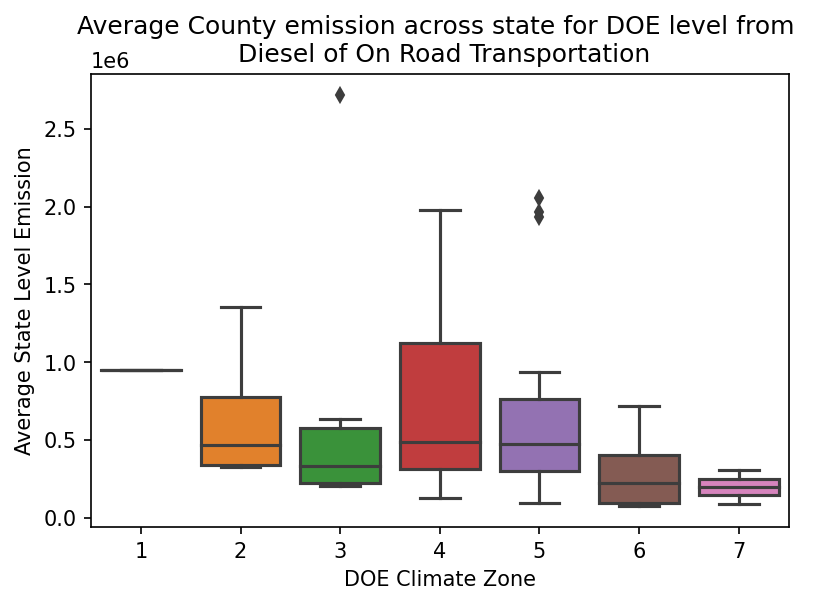

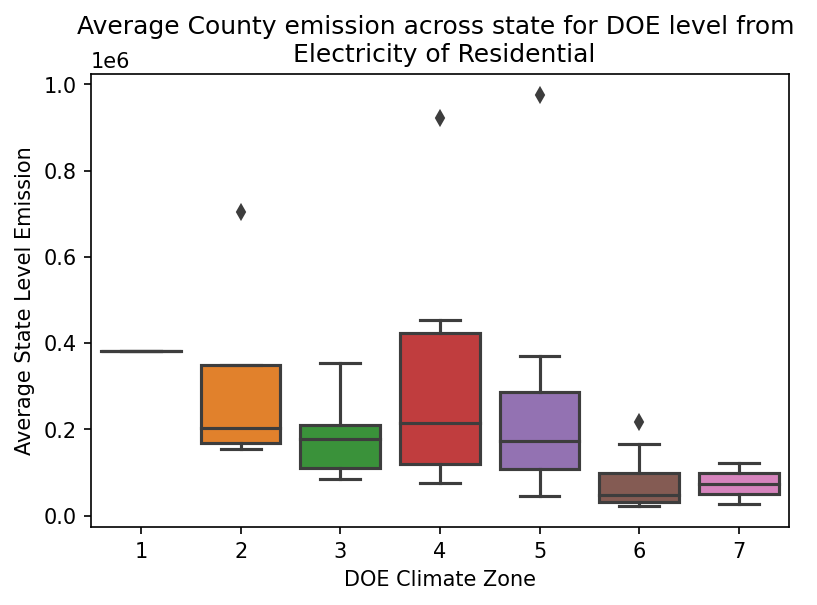

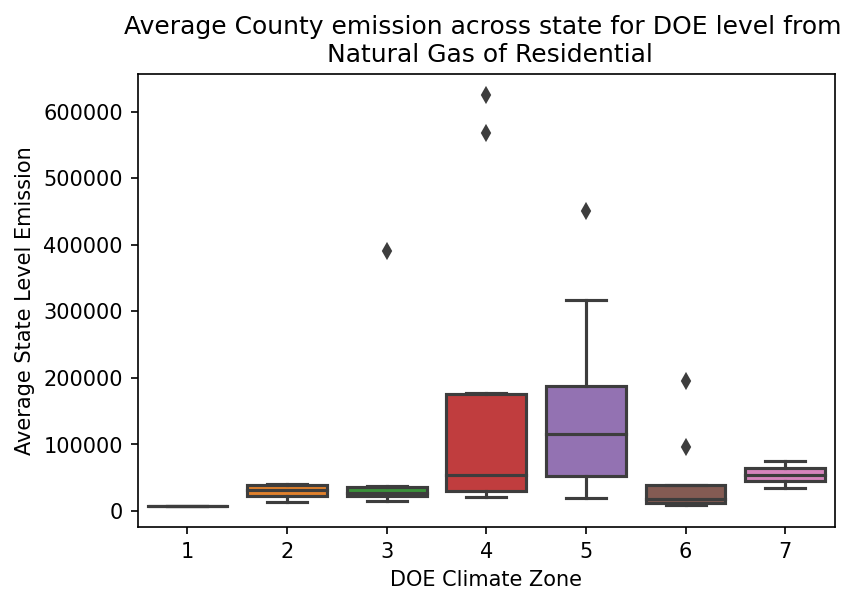

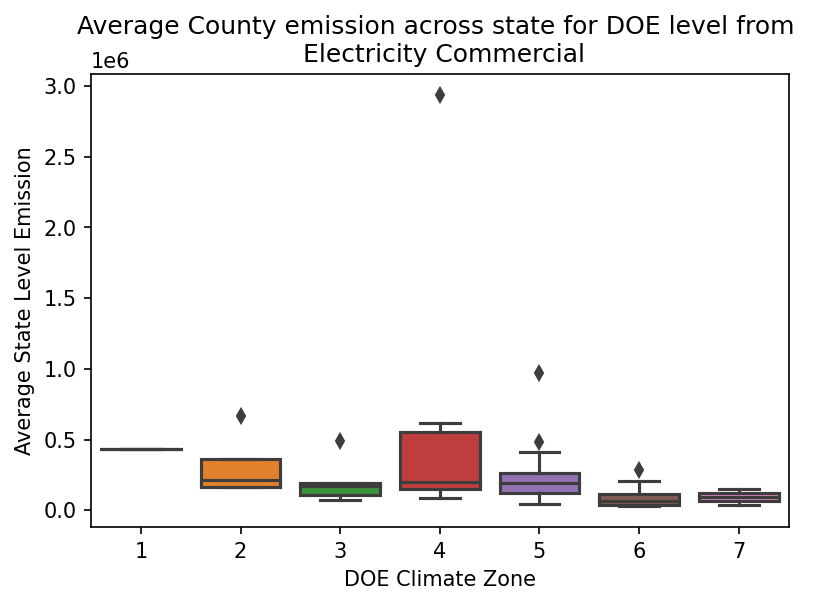

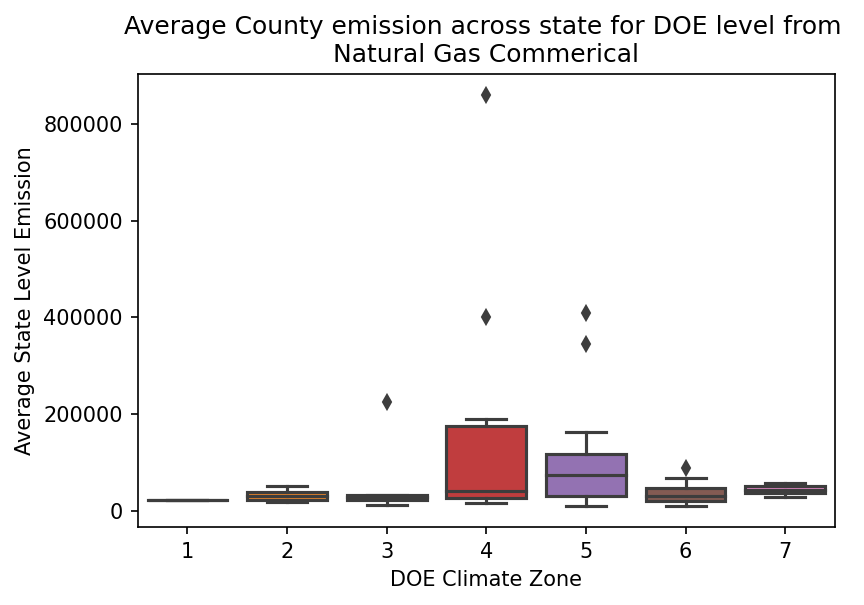

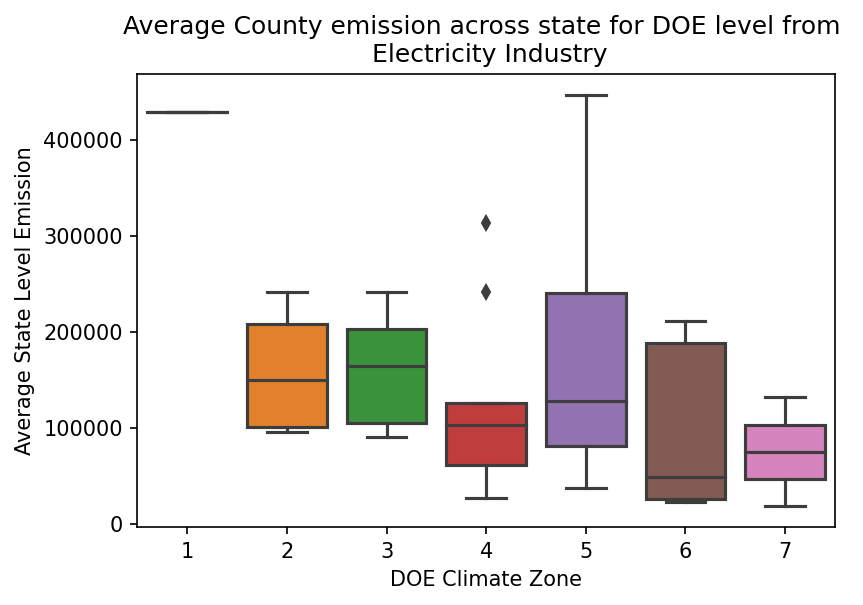

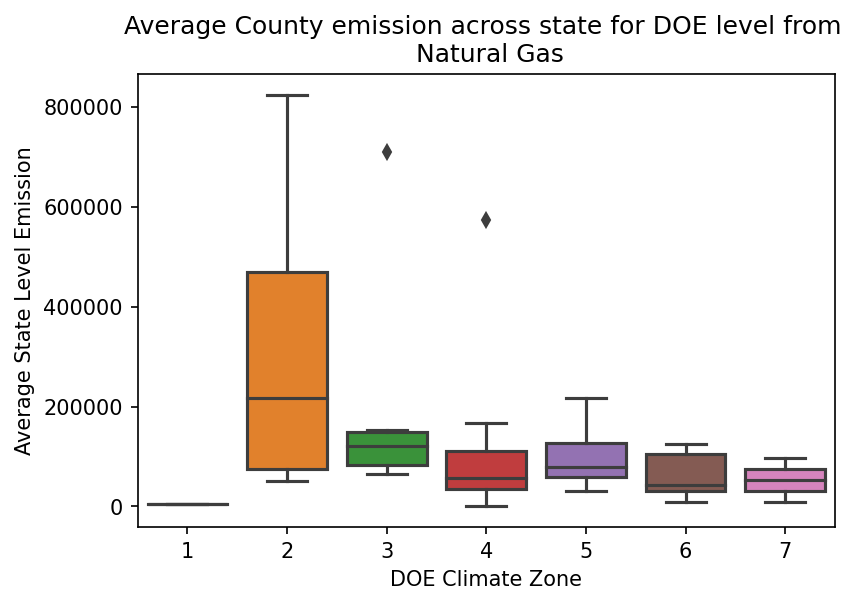

In [72]:

for  i,(name , icol) in enumerate(col_name_paris): 
    plt.figure(dpi=150)
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s['avg_emission']=  e[icol].mean()  
        s['doe_zone']=  e['doe_climate_zone'].iloc[0] 
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y='avg_emission')
    plt.title(f"Average County emission across state for DOE level from \n {name}") 
    plt.ylabel("Average State Level Emission")
    plt.xlabel("DOE Climate Zone")



<AxesSubplot:xlabel='avg_emission', ylabel='Count'>

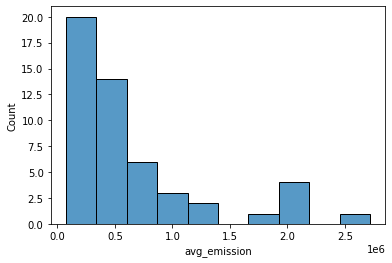

<AxesSubplot:xlabel='doe_zone', ylabel='avg_emission'>

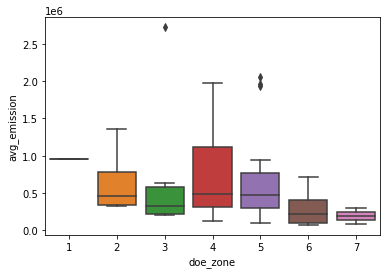

In [24]:
sns.boxplot(data=plot_df,y='avg_emission',x='doe_zone')

<AxesSubplot:xlabel='On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'>

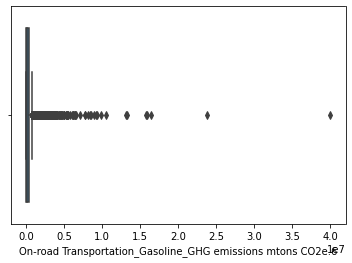

In [22]:
i_col = 'On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'
sns.boxplot( data=data,x=i_col,)